<a href="https://colab.research.google.com/github/RaianaSeixas/Portfolio/blob/main/Optimization/L_SHADE_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this code a **solution method for optimization problems called L-SHADE** is implemented and tested using Rastringin benchmark function.

The implementation is based in the original algorithm of the authors available in the link:
https://ieeexplore.ieee.org/document/6900380

L-SHADE is an improvement of Diferencial Evolution algorithm (DE), which is a populational method inspired in species evolution which minimizes or maximizes an objective function over the course of successive iterations. DE has been extensively explored and it was considered a simple and efficient methodology able to outperform many evolutionary algorithms and other heuristics methods while solving both benchmark and real-world problems.



In [1]:
import numpy as np
import scipy.stats
import random

In [2]:
# Parameters
dim = 3 #dimension 
lb=10 #bounds
NPAR1 = 100 # individuals 
ITERATIONS = 200

##########################
MAX=np.repeat(lb,dim)
MIN=np.repeat(-lb,dim)
popsize = NPAR1
H = 6
kH = 0 # kH is used to work with H  
SF=[];SCR=[];MF=[];MCR=[];Xarq=[]
terminal = 0.1

p=0.1
MFi=0.5
MCRi=0.5

In [3]:
'''Test Problems'''

'''
# HappyCat function
# global mimima 0 at (-1,-1,...,-1)
# Not convex and non separable it is usually evaluated at xi =[(-600,600),..(-600,600)]

def fobj(x): 
    alpha=1. / 8
    s = sum(x**2) 
    return ((s - len(x))**2)**alpha + (s / 2 + sum(x)) / len(x) + 0.5 
'''
# Rastrigin Function
# Multimodal and separable
def fobj(x):
  return 10 * len(x) + sum([np.power(i, 2.) - 10 * np.cos(2 * np.pi * i) for i in x])
  # global mimima 0 at (0,0,...,0)


In [4]:
def LShade(MAX,MIN, popsize,fobj,setTUNE,best,fbest,fitness,X,Xarq,FES):

  SF,SCR,MF,MCR,p, terminal, Narquive,H,kH = setTUNE

  fmutant = []
  Xmutant = []
  fx=[]; fu=[] # to select the wij Lehmer Mean.
  # setTUNE = [SF,SCR,MF,MCR,p, terminal, Narquive,H] 
  dim = X.shape[1]
  #best_number = int(p*popsize)
  if (p*popsize<1):
    best_number=1
  else:
    best_number = int(p*popsize)
  justGoOUT=1

  if(justGoOUT==1):
    SCR =[];SF=[];
    for i in range(popsize):
      ri = random.randint(0,H-1) # line 7
      miF = MF[ri]
      miCR = MCR[ri]
      if(MCR[ri] == terminal):
        miCR = 0
        crossp = 0
      else:
        crossp = np.random.normal(miCR , 0.1)
      while (True):
        mut = scipy.stats.cauchy.rvs(loc=miF, scale=0.1)
        if (mut > 0):
          break
      if(mut > 1.0): mut =1.0
      if(crossp > 1.0): crossp =1
      if(crossp < 0): crossp = 0 

      ind = fitness.argsort()[range(best_number)] # find index of best p*popsize
      best_idx = random.choice(ind) # index of the best in p*popsize (random best)
      pbest = X[best_idx] # random best 
      idxs = [idx for idx in range(popsize) if idx != i]
      iused = np.random.choice(idxs, 1, replace = False)
      idxs = [idx for idx in range(popsize) if (idx != iused and idx != best_idx)]
      a  = X[iused]
      if(len(Xarq)>0):
        Xii = np.asarray(Xarq)
        Xnew = np.append(X[idxs,:],Xii,axis=0)
      else:
        Xnew=np.copy(X[idxs,:])

      idxs2 = [idx for idx in range(len(Xnew[:,0])) if 2 > 1]
      b  = Xnew[np.random.choice(idxs2, 1, replace = False)]

      mutant = X[i,:]+mut*(pbest-X[i,:]) + mut * (b - a)
      mutant = mutant.ravel()

      #trial = np.copy(mutant)
      trial = np.copy(X[i,:])

      jrand = random.randint(0,dim-1)

      for j in range(dim):
        rdn = np.random.rand()
        if(rdn < crossp or j == jrand) : 
          trial[j] = mutant[j] 
        else:
          trial[j] = X[i,j]

      mutant  = np.copy(trial) # just to use word mutant instead of trial
      
      for k in range(dim):
        if(mutant[k]>MAX[k]):
          mutant[k]=MAX[k]
        if(mutant[k]<MIN[k]):
          mutant[k]=MIN[k]

      Xmutant.append(mutant)

      FES = FES + 1
      fmut =fobj(mutant)
      fmutant.append(fmut)
    
      #for i in range(popsize):
      if( fmutant[i]  <= fitness[i]):
        Xold = X[i,:] 
        X[i,:] = Xmutant[i]
        fx.append(fitness[i])
        fu.append(fmutant[i])
        fitness[i]=fmutant[i]
        SCR.append(crossp)
        SF.append(mut)

        sizeARQ = np.array(Xarq).shape[0]
        if(sizeARQ < Narquive):
          Xarq.append(Xold)
        else:
          ri = random.randint(0, Narquive-1) # deleting individuals if necessary
          Xarq[ri] = Xold

        if(fbest >= fmutant[i]):
          best = Xmutant[i]
          fbest = fmutant[i]
      else:
        X[i,:] = X[i,:] # it is not necessary this line but just to remeber it

    
    # memory update algorithm 1:
    if(kH > H-1): kH = 0

    if (len(SCR)>0):
      deltaF = np.abs(np.asarray(fu)-np.asarray(fx))
      if( sum(deltaF) > 0):
        w = deltaF/sum(deltaF)
      else:
        w =np.ones(len(fu))
      if(MCR[kH] == terminal or max(SCR)==0):
        MCR[kH] = terminal
      else:
        y = np.asarray(SCR)
        MCR[kH] = np.dot(w,y**2)/np.dot(w,y)
      y = np.asarray(SF)
      MF[kH] = np.dot(w,y**2)/np.dot(w,y)
      kH = kH + 1

    else:
      MCR = MCR
      MF = MF

  setTUNE =[SF,SCR,MF,MCR,p, terminal, Narquive,H,kH]


  y=fitness


  XY= np.c_[X,y] #concatena x e y em 2 colunas            
  XYsorted = XY[XY[:,-1].argsort()] #Ordena a partir da last col(Y) for all row
  X=XYsorted[:,0:dim]
  XY=XYsorted
  fitness = XYsorted[:,-1]  
  BEST=X[0,:]
  FOBEST=fitness[0]
  BEST_XY =np.append(BEST,FOBEST)
  
  return fitness,X,BEST,FOBEST,XY,BEST_XY,FES,Xarq,setTUNE


In [5]:
X=np.zeros((NPAR1,dim))
for i in range(NPAR1):
  for j in range(dim):
    r=np.random.random()
    X[i,j]=r*(MAX[j]-MIN[j])+MIN[j]

FES = 0
X1 = np.copy(X)
fit1 = np.asarray([fobj(ind) for ind in X1])
FES = FES + NPAR1
best_idx = np.argmin(fit1)
best = X1[best_idx]
fbest = fit1[best_idx] 
BEST1,FOBEST1 = best, fbest

In [6]:
for i in range(H):
  MCR.append(MCRi);MF.append(MFi)
Narquive = popsize
setTUNE =[SF,SCR,MF,MCR,p, terminal, Narquive,H,kH]

In [7]:
for i in range(ITERATIONS):
  
  fit1,X1,BEST1,FOBEST1,XY,BEST_XY,FES,Xarq,setTUNE= LShade(MAX,MIN, popsize,fobj,setTUNE,best,fbest,fit1,X1,Xarq,FES)
  if i%10==0:
    print('i=',i,'FOBJ=',FOBEST1)


i= 0 FOBJ= 19.037835272078965
i= 10 FOBJ= 7.602520056906325
i= 20 FOBJ= 2.074282175342134
i= 30 FOBJ= 1.3514197158476087
i= 40 FOBJ= 0.27294222293586046
i= 50 FOBJ= 0.10164480947942067
i= 60 FOBJ= 0.027596365941285228
i= 70 FOBJ= 0.0003399637822028012
i= 80 FOBJ= 8.230541183706919e-06
i= 90 FOBJ= 4.3631909818486747e-07
i= 100 FOBJ= 2.498618556501242e-08
i= 110 FOBJ= 4.460218860913301e-10
i= 120 FOBJ= 3.4013680760835996e-11
i= 130 FOBJ= 3.979039320256561e-13
i= 140 FOBJ= 3.197442310920451e-14
i= 150 FOBJ= 0.0
i= 160 FOBJ= 0.0
i= 170 FOBJ= 0.0
i= 180 FOBJ= 0.0
i= 190 FOBJ= 0.0


In [8]:
print('Result found by the solver (Target=0) :',fobj(X1[0,:]))

Result found by the solver (Target=0) : 0.0


In [9]:
#setTUNE[2]# =[SF,SCR,MF,MCR,p, terminal, Narquive,H,kH]

In [10]:
#setTUNE[3]# =[SF,SCR,MF,MCR,p, terminal, Narquive,H,kH]

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


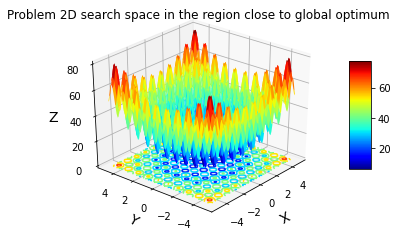

In [57]:
'''Vizualization of the problem 2D search space in the region close to global optimum'''
"""
Created on Mon Jul  1 18:01:53 2019
@author: rrs
"""

from math import *
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
#if using a Jupyter notebook, include: %matplotlib inline

#Abrir gráfico em nova janela
#from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'qt')

step = 0.1

lb=5

xx = np.arange(-lb,lb,step)
yy = np.arange(-lb,lb,step)
N=len(xx)
NN = N*N
zz =np.zeros((N,N))
X,Y = np.meshgrid(xx,yy)
x=np.zeros(2)

for i in range(N):
    for j in range(N):
        x[0]=xx[i]; x[1]=yy[j];
        
        W=fobj(x)
        
#        print(W)
        zz[i,j]=W*1.0;


Z = zz.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.grid(False) # esconder linhas de grade
#mycmap = plt.get_cmap('gist_earth')

ax.azim = -140
ax.elev = 30
ax.view_init(ax.elev, ax.azim)

mycmap = plt.get_cmap('jet')
#ax.set_title('gist_earth color map')
#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
surf1 = ax.plot_surface(X, Y, Z, cmap=mycmap)
#surf1 = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5)

cset = ax.contour(X, Y, Z,6, zdir='z', offset=-0.5, cmap=mycmap)
plt.xlabel('X',fontsize=14, rotation=-150)
plt.ylabel('Y',fontsize=14, rotation=-30)
ax.set_zlabel('Z',fontsize=14)
plt.title('Problem 2D search space in the region close to global optimum')
plt.show()